In [6]:
import linearmodels as lm
import pandas as pd
import seaborn as sns
import re 
%matplotlib inline

In [7]:
# Data Prep
# Import and reshape bankruptcies
# Import the data
Bankruptcies = pd.read_csv("Bankruptcies.csv", index_col=0) 

#simplify column names
def simplify_name(s):
    p = re.compile('Personal Bankruptcies (.*)  - Bankruptcies\n  - #')
    result = p.search(s)
    return result.group(1)

new_names = [simplify_name(name) for name in Bankruptcies.columns]
Bankruptcies.columns = new_names


# reshape dataframe using a year x state index
def reshape_dataframe(df, col_name=''):
    df = df.stack()
    df.index.names = ['Year', 'State']
    df.index
    return df.sort_index().to_frame(col_name)
        
Bankruptcies = reshape_dataframe(Bankruptcies, 'Bankruptcies')
Bankruptcies.head()

Bankruptcies
Year State                   
2006 Alabama            19546
     Alaska               579
     Arizona             7536
     Arkansas            9290
     California         37171

In [8]:
#Import and reshape income
#Import the data
Income = pd.read_csv( "Income.csv")
Income['GeoName'] = Income['GeoName'].apply(lambda x: x.rstrip(' ').rstrip(' *'))

Income = Income.set_index('GeoName')

# in our context, when the year corresponds to a column, it's stored as a string
print(Income.columns)
#Index(['2006', '2007', '2008', '2009', '2010', '2011', '2012'], dtype='object')

# the function below makes sure the year is treated as a number when we transpose


def transpose_dataframe(df):
    
    df.columns = df.columns.astype(int) 
    return df.T

Income = reshape_dataframe(transpose_dataframe(Income), 'Income')

# The Year index is indeed treated as an Integer
print(Income.index.levels[0])
#Int64Index([2006, 2007, 2008, 2009, 2010, 2011, 2012], dtype='int64', name='Year')

Income.head()

Index(['2006', '2007', '2008', '2009', '2010', '2011', '2012'], dtype='object')
Int64Index([2006, 2007, 2008, 2009, 2010, 2011, 2012], dtype='int64', name='Year')


Income
Year State             
2006 Alabama      31306
     Alaska       40881
     Arizona      34667
     Arkansas     29422
     California   42139

In [9]:
#Import and reshape Law_Restrictions
#Import data

Law_Restrictions = pd.read_csv("Bhutta_Law_Restrictions.csv", index_col=0)

# reshape dataframe using a year x state index
def reshape_dataframe(df, col_name=''):
    df = df.stack()
    df.index.names = ['Year', 'State']
    df.index
    return df.sort_index().to_frame(col_name)

Law_Restrictions = reshape_dataframe(transpose_dataframe(Law_Restrictions), 'Law_Restrictions')# reshape dataframe like we did for Income
Law_Restrictions.head()

Law_Restrictions
Year State                       
2006 Alabama                    0
     Alaska                     0
     Arizona                    0
     Arkansas                   0
     California                 0

In [10]:
#Merge data
#Merge Bankruptcies with income to create DiD data
data = pd.concat([Bankruptcies, Income, Law_Restrictions], axis=1, sort=False)
data = data.dropna()
data.head()

Bankruptcies   Income  Law_Restrictions
Year State                                              
2006 Alabama          19546.0  31306.0               0.0
     Alaska             579.0  40881.0               0.0
     Arizona           7536.0  34667.0               0.0
     Arkansas          9290.0  29422.0               0.0
     California       37171.0  42139.0               0.0

      Bankruptcies        Income
Year                            
2006  12358.479167  37034.375000
2007  16868.312500  38836.625000
2008  22059.645833  40181.000000
2009  29034.208333  38792.750000
2010  31602.062500  40020.062500
2011  26392.854167  42234.416667
2012  24274.270833  44039.958333
        Bankruptcies        Income  Law_Restrictions
count     336.000000    336.000000         336.00000
mean    23227.119048  40162.741071           0.28869
std     29156.639949   6588.660518           0.45383
min       579.000000  27907.000000           0.00000
25%      4894.000000  35355.250000           0.00000
50%     15261.000000  39267.000000           0.00000
75%     32364.750000  43676.000000           1.00000
max    251294.000000  64958.000000           1.00000


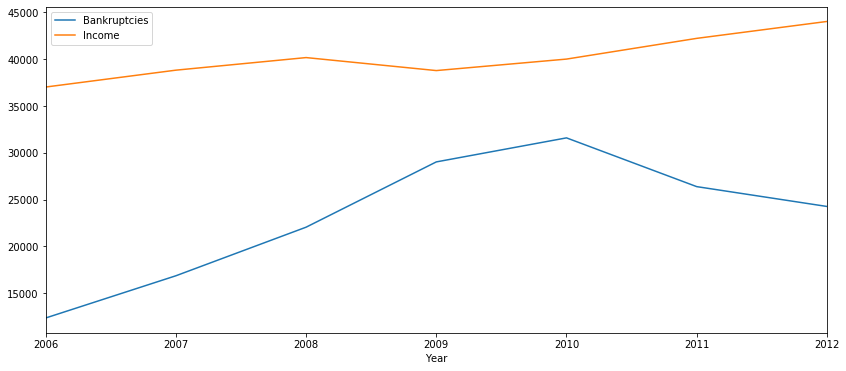

In [11]:
#Report summary statistics
#For Bankruptcies
trends_bkrpt_inc = data.groupby(level=0)[['Bankruptcies','Income']].mean()
print(trends_bkrpt_inc)
trends_bkrpt_inc.plot(figsize=(14,6))

# add summary stats for 2011
print(data.describe())

      Law_Restrictions
Year                  
2006          0.229167
2007          0.229167
2008          0.250000
2009          0.291667
2010          0.312500
2011          0.354167
2012          0.354167


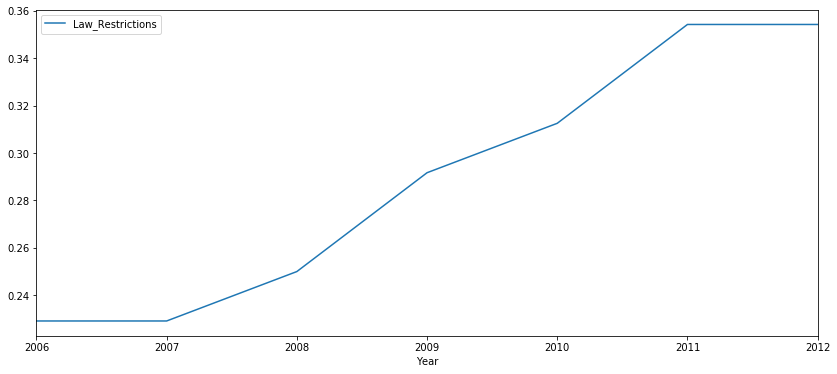

In [12]:
#Analysis
#Report how many states have laws restricting payday lending for each of the years using a bar graph
#Use aggregate function to aggregate Law Restrictions by year

trends_restrict = data.groupby(level=0)[['Law_Restrictions']].mean()
print(trends_restrict)
trends_restrict.plot(figsize=(14,6))

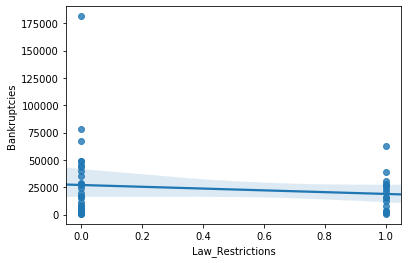

In [13]:
#Plot the relationship using a scatterplot between bankruptcy rates and payday lending restrictions for the latest year for which we have data.

sns.regplot(y='Bankruptcies', x='Law_Restrictions', data=data.loc[2012, :])

In [14]:
#Estimate the regression coefficient for the relationship bankruptcies and law restrictions
model = lm.OLS.from_formula('Bankruptcies~ Law_Restrictions', data=data.loc[2012, :])
                            
res = model.fit()
print(res.summary)

                            OLS Estimation Summary                            
Dep. Variable:           Bankruptcies   R-squared:                      0.0174
Estimator:                        OLS   Adj. R-squared:                -0.0040
No. Observations:                  48   F-statistic:                    1.2518
Date:                Thu, Jan 27 2022   P-value (F-stat)                0.2632
Time:                        01:33:40   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                                Parameter Estimates                                 
                  Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------------
Intercept         2.716e+04     6208.5     4.3753     0.0000     1.5e+04   3.933e+04
Law_Restrictions    -8158.2 

I would not interpret the correlation as evidence that payday lending laws cause bankruptcies to increase or decrease. This is because it is likely that there is omitted variable bias happening. We realize that bankruptcies can be affected by other variables such as interest rate and other economic variables.

In [15]:
#Perform a diff-in-diff analysis without the income control and report the estimates

# the typical panel data convention is to have the entity correspond to the first index, and the time correspond to the second index
# the *linearmodel* package needs us to follow that convention

if data.index.names[0] == 'Year':
    data = data.swaplevel(i=0, j=1)
    data = data.sort_index()
    
print(data.head(), '\n\n')

reg_formula = 'Bankruptcies ~ 0 + EntityEffects + TimeEffects + Law_Restrictions' 

model = lm.PanelOLS.from_formula(reg_formula, data=data.dropna())
res = model.fit()
print(res.summary)

              Bankruptcies   Income  Law_Restrictions
State   Year                                         
Alabama 2006       19546.0  31306.0               0.0
        2007       23572.0  32573.0               0.0
        2008       29018.0  33377.0               0.0
        2009       34180.0  32631.0               0.0
        2010       33403.0  33844.0               0.0 


                          PanelOLS Estimation Summary                           
Dep. Variable:           Bankruptcies   R-squared:                        0.0015
Estimator:                   PanelOLS   R-squared (Between):             -0.0269
No. Observations:                 336   R-squared (Within):              -0.0064
Date:                Thu, Jan 27 2022   R-squared (Overall):             -0.0245
Time:                        01:33:42   Log-likelihood                   -3604.6
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:

The coefficient for the dummy representing legal restrictions on payday lending is -2684.6
This is statistically significantly different from zero.

In [16]:
#Adding the control variable 
#How do the results change?

reg_formula_income = 'Bankruptcies ~ 0 + EntityEffects + TimeEffects + Law_Restrictions + Income'

model = lm.PanelOLS.from_formula(reg_formula_income, data=data.dropna())
res = model.fit()
print(res.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:           Bankruptcies   R-squared:                        0.0501
Estimator:                   PanelOLS   R-squared (Between):             -9.0779
No. Observations:                 336   R-squared (Within):              -0.2672
Date:                Thu, Jan 27 2022   R-squared (Overall):             -8.0534
Time:                        01:33:44   Log-likelihood                   -3596.2
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      7.3798
Entities:                          53   P-value                           0.0008
Avg Obs:                       6.3396   Distribution:                   F(2,280)
Min Obs:                       0.0000                                           
Max Obs:                       7.0000   F-statistic (robust):             7.3798
                            

The estimated coefficient for the dummy representing legal restrictions on payday lending changes noticeably from -2684.6 to -4018.8
The estimated coefficient for Income is -2.0648

The magnitude of the income coefficient is small at -2.0648, but the relationship between income and bankruptcies is significant. 
The magnitude of the payday lending restrictions coefficient is large at -4018.8, but the relationship between the payday lending restrictions and bankruptcies is sinignificant.

We should still be concerned with omitted variables bias now. It is likely that we are not accounting for all existing variables so our estimator may not be correct.

A nudge is any aspect of the choice architecture that alters people's behavior in a predictable way without forbidding any options or significantly changing their economic incentives. In our case, the CFPB tries to stop payday debt traps by requiring lenders to determine upfront whether people can afford to repay their loans. The law protections require consumers to repay all of most of the debt at once, including payday loans, auto loans, long-term loans with balloon payment etc. 
There for few specific protections: 
1. With Full-Payment tests Lenders are required to determine whether the borrower can afford the loan payment and still meet basic living expenses and major financial obligations. 
2. The Principal-payoff option lets consumers take out a short-term loan of up to $500 without the full-payment test if it is structured to allow the borrower to get out of the debt more gradually. 
3. Some less risky loan options are available such as loans that pose less risk to consumers do not require the full-payment test or the principal-payoff option. 
The relationship between income and bankruptcies is significant, and the regulations on income should be established. In this case, by doing a full-payment test, it acts as a pre-screening to lend loans only to those who have relatively high incomes and hence will have the ability to pay back their loans in the future. 